In [14]:
import os
import re
from pathlib import Path
import pandas as pd
from functools import reduce
from tqdm import tqdm

# Define a regex pattern to match the variable part of the file names
file_template = r"([^/]+)_([^/]+)_event_(\d+)/([\w-]+)\.parquet"

def extract_file_info(file_path):
    """Extract information from a file path using regex."""
    match = re.match(file_template, str(file_path))
    if match:
        mriot_name, inv_sce, event_id, variable = match.groups()
        return mriot_name, inv_sce, int(event_id), variable
    else:
        return None

def build_nested_dict(file_dict):
    """Build a nested dictionary from a dictionary of file paths."""
    nested_dict = {}
    for key, value in file_dict.items():
        mriot, inv_sce, event_id, variable = key
        mriot_dict = nested_dict.setdefault(mriot, {})
        inv_sce_dict = mriot_dict.setdefault(inv_sce, {})
        variable_dict = inv_sce_dict.setdefault(variable, {})
        variable_dict[event_id] = value
    return nested_dict

def compute_difference(file_paths, progress=False):
    """Compute the difference between all events and each event individually."""
    results = {}
    for mriot, mdict in file_paths.items():
        for inv_sce, inv_dict in mdict.items():
            for var, var_dict in inv_dict.items():
                all_ev_files = []
                if progress:
                    var_dict_iter = tqdm(var_dict.items(), desc=f"Processing {mriot}/{inv_sce}/{var}")
                else:
                    var_dict_iter = var_dict.items()
                
                for ev_id, file in var_dict.items():
                    all_ev_files.append(pd.read_parquet(file))
                
                all_ev_result = reduce(lambda x, y: x.add(y - y.loc[0], fill_value=0), all_ev_files)
                results.setdefault(mriot, {}).setdefault(inv_sce, {}).setdefault(var, {})[-99] = all_ev_result
                
                for ev_id_x, _ in var_dict_iter:
                    ev_x_files = []
                    for ev_id, file in var_dict.items():
                        if ev_id != ev_id_x:
                            ev_x_files.append(pd.read_parquet(file))
                    
                    ev_x_result = reduce(lambda x, y: x.add(y - y.loc[0], fill_value=0), ev_x_files)
                    difference = all_ev_result - (ev_x_result - ev_x_result.loc[0])
                    results.setdefault(mriot, {}).setdefault(inv_sce, {}).setdefault(var, {})[ev_id_x] = difference
    return results

def process_res_df(res_dict, sample_n, mriot, invtype, event_id, var):
    df = res_dict[mriot][invtype][var][event_id].copy()
    df_sum = (df-df.loc[0]).sum(axis=0).T.groupby("region").sum().T.to_frame("total indirect impact")
    df_sum["sample"] = sample_n
    df_sum["MRIOT"] = mriot
    df_sum["invtype"] = invtype
    df_sum["event_id"]= event_id
    df_sum["variable"] = var
    return df_sum

import pandas as pd

def aggregate_results(res_dict,sample_n):
    """Aggregate results from the nested dictionary and all_results_df."""
    aggregated_results = pd.DataFrame()
    
    for mriot, mdict in res_dict.items():
        for invtype, inv_dict in mdict.items():
            for var, var_dict in inv_dict.items():
                for event_n in var_dict.keys():
                    # Process individual results using process_res_df function
                    df = process_res_df(res_dict, sample_n, mriot, invtype, event_n, var).reset_index()

                    # Append the processed result to the aggregated results DataFrame
                    aggregated_results = pd.concat([aggregated_results, df], ignore_index=True)
    
    # Merge the aggregated results with all_results_df
    #merged_df = pd.merge(all_results_df, aggregated_results, on=['sample', 'MRIOT', 'invtype', 'event_id', 'variable'], how='left')
    
    return aggregated_results


In [40]:
sample_number = 78
sample_directory = Path(f"../outputs/sample_{sample_number}/")

# Create a dictionary to store the key-value pairs
file_dict = {}

# Iterate through the directory and its subdirectories
for file in sample_directory.rglob("*.parquet"):
    file_path = Path(file.parents[0].name + "/" + file.name)
    file_info = extract_file_info(file_path)
    if file_info:
        file_dict[file_info] = file.resolve()

# Build a nested dictionary from the file_dict
nested_dict = build_nested_dict(file_dict)

# Compute the difference between all events and each event individually
results = compute_difference(nested_dict, progress=True)

# Now, 'results' contains the computed differences

Processing OECD21-2018/9-6/final_demand_unmet: 100%|█| 22/22 [00:26<00:00,
Processing OECD21-2018/9-6/production_realised: 100%|█| 22/22 [00:27<00:00
Processing OECD21-2018/90-60/final_demand_unmet: 100%|█| 22/22 [00:26<00:0
Processing OECD21-2018/90-60/production_realised: 100%|█| 22/22 [00:27<00:


In [76]:
EU_regs_wiod = ["AUT","BEL","BGR","CHE","DEU","DNK","EST","ESP","FIN","FRA","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","NOR","POL","PRT","ROU","SWE","SVN","SVK"]

indirect_impact_from_all_ev = results["OECD21-2018"]["9-6"]["production_realised"][-99]

EU_dfs = []
for country in EU_regs_wiod:
    try:
        EU_dfs.append(indirect_impact_from_all_ev[country])
    except:
        continue
indirect_impact_from_all_ev_eu = pd.concat(EU_dfs).groupby(level=0).sum()
indirect_impact_from_all_ev_eu_norm = indirect_impact_from_all_ev_eu / indirect_impact_from_all_ev_eu.loc[0]

# Plot sample time series direct/indirect impacts 

In [47]:
import pickle as pkl
with open("../outputs/sample_78/direct_impact.pkl",'rb') as f:
        direct_impact = pkl.load(f)
direct_impact.unit = '$'
impact_at_reg = direct_impact.impact_at_reg()

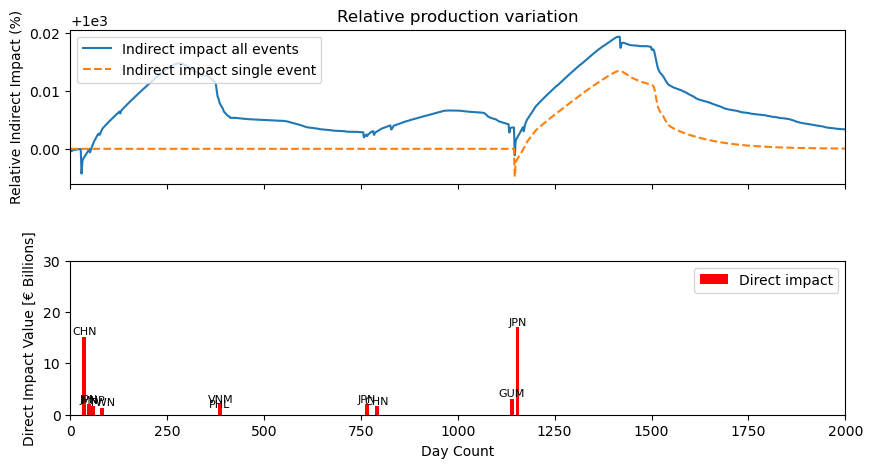

In [142]:
# Create a figure with two subplots stacked vertically and sharing the x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5), sharex=True)
fig.subplots_adjust(hspace=0.5)  # Adjust the value as needed

# Your code for setting up EU_regs_wiod and indirect_impact_from_all_ev...

# Plotting on ax1 (top subplot) and multiply values by 100
ax1.plot(indirect_impact_from_all_ev_eu_norm.index, indirect_impact_from_all_ev_eu_norm.sum(axis=1) * 100, label='Indirect impact all events')
ax1.set_title("Relative production variation")
ax1.set_ylabel('Relative Indirect Impact (%)')  # Adjusted label to indicate percentage

# Your code for setting up indirect_impact_worst_event...

# Continue plotting on ax1 (top subplot) and multiply values by 100
ax1.plot(indirect_impact_worst_event_norm.index, indirect_impact_worst_event_norm.sum(axis=1) * 100, label='Indirect impact single event', linestyle='--')
ax1.legend(loc='upper left')

# Plotting on ax2 (bottom subplot)
valid_indices = ~pd.isna(direct_impact.date) & ~pd.isna(direct_impact.at_event) & (direct_impact.at_event>1e9)
bar_width = 10


# mm removing 205 so the axis fit, but still not sure where this comes from tbh
bars = ax2.bar(direct_impact.date[valid_indices]-205, direct_impact.at_event[valid_indices]/1e9, width=bar_width, color='r', label='Direct impact', alpha=1)
ax2.set_ylabel('Direct Impact Value [€ Billions]')
ax2.set_ylim(0,30)
ax2.set_xlim(0,2000)
ax2.legend(loc='upper right')

for bar, label in zip(bars, impact_at_reg.idxmax(axis=1)):
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, label, va='bottom', ha='center', color='black', size=8)

# Only set xlabel for the bottom subplot
ax2.set_xlabel('Day Count')

# Show the combined plot with both subplots
plt.savefig("temporal_series_sample_78.pdf")


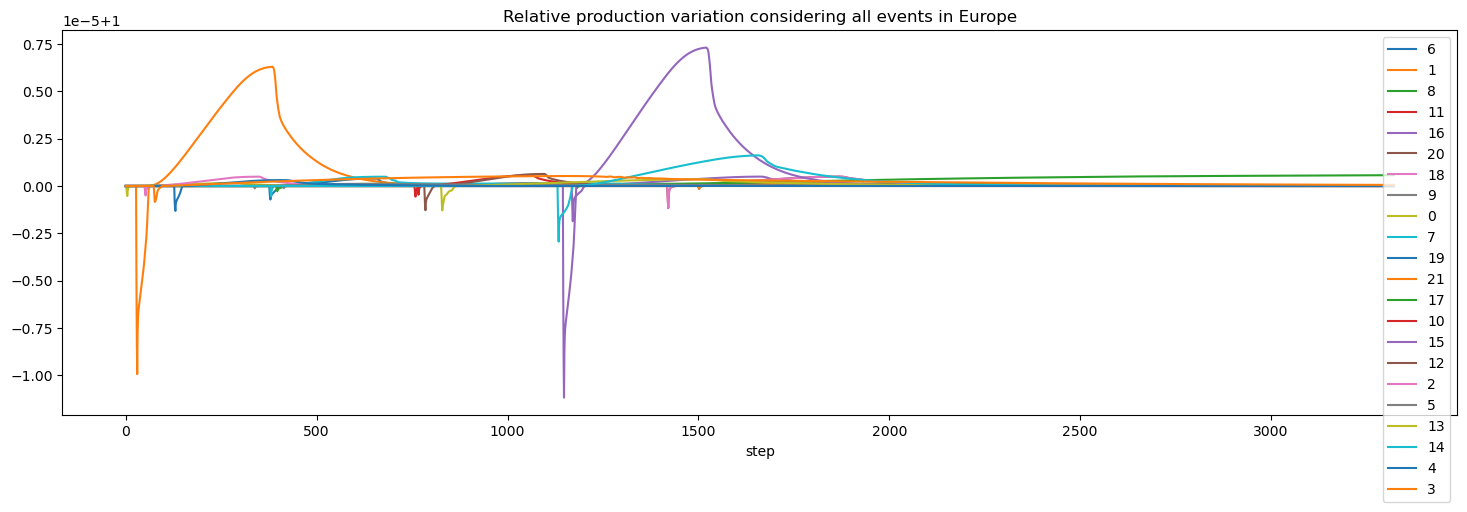

In [143]:
for event in results["OECD21-2018"]["9-6"]["production_realised"].keys():
    if event != -99:
        indirect_impact_worst_event = results["OECD21-2018"]["9-6"]["production_realised"][event]
        EU_dfs =[]
        for country in EU_regs_wiod:
            EU_dfs.append(indirect_impact_worst_event[country])
        indirect_impact_worst_event_eu = pd.concat(EU_dfs).groupby(level=0).sum()

        indirect_impact_worst_event_norm = indirect_impact_worst_event_eu / indirect_impact_worst_event_eu.loc[0]

        indirect_impact_worst_event_norm['Transport'].plot(label=event, figsize=(18,5), title="Relative production variation considering all events in Europe")
        plt.legend()

<AxesSubplot:title={'center':'Relative production variation considering all events in Europe'}, xlabel='step'>

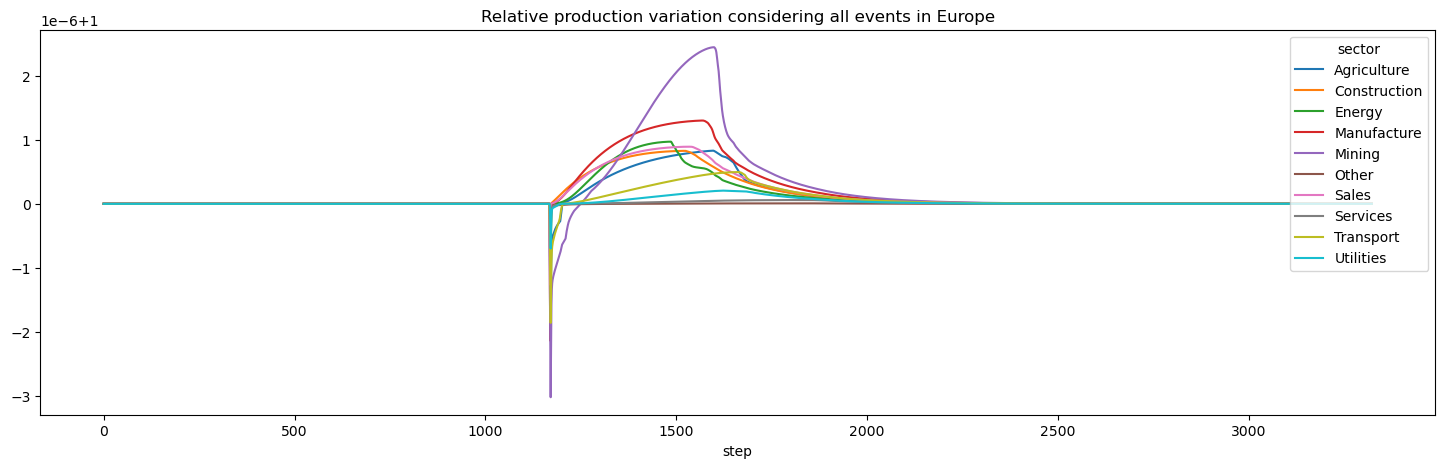

In [145]:


indirect_impact_worst_event_norm.plot(figsize=(18,5), title="Relative production variation considering all events in Europe")

In [161]:
# Make gif of direct impacts

In [152]:
impact_at_reg = direct_impact.impact_at_reg()

In [152]:
impact_at_reg['date'] = direct_impact.date.astype(int)

In [153]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [147]:
from datetime import datetime, timedelta

def convert_day_count_to_date(day_count, start_year=1):
    """
    Convert a day count into a formatted date string.

    Parameters:
    - day_count (int): The day count to convert.
    - start_year (int): The year corresponding to day_count=1.

    Returns:
    - str: A string representing the date in the format "DD.MM Year Y".
    """
    # Create a start date
    start_date = datetime(start_year, 1, 1)
    
    # Calculate the new date by adding the day count (minus one to start counting from 1)
    new_date = start_date + timedelta(days=day_count - 1)
    
    # Format the new date as a string
    date_str = new_date.strftime("%d.%m Year %Y")
    
    return date_str


In [156]:
import pandas as pd

max_day_count = 365*5

# Assuming df is your original DataFrame and it has a 'date' column
# Also assuming that you have a list of country codes as column names

# Creating a new DataFrame with all desired days
all_days = pd.DataFrame({'date': range(1, max_day_count + 1)})

# Merging the original data with the all_days DataFrame to include missing days
merged_df = pd.merge(all_days, impact_at_reg, on='date', how='left', sort=True)

# Filling NaN values with 0 for days without data
merged_df.fillna(0, inplace=True)

In [418]:
impact_at_reg_sorted

,ABW,AFG,AGO,ALB,AND,ARE,ARG,ARM,ASM,ATG,...,VEN,VIR,VNM,VUT,WSM,YEM,ZAF,ZMB,ZWE,date
24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,108
29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,184
18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,221
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,230
168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,236
30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,249
22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,261
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,276
34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,302
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,303


In [159]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd


# ... [Other code, such as reading your data, defining convert_day_count_to_date, etc.]

# Ensure the data is sorted by date in ascending order
impact_at_reg_sorted = impact_at_reg.sort_values(by='date')

start_year = 1  # Adjust if a different year is desired for day_count=1

for index, row in impact_at_reg_sorted.iterrows():
    # Convert day count to formatted date string
    formatted_date = convert_day_count_to_date(int(row['date']), start_year=start_year)
    
    # Create a dictionary {country: impact, ...}
    impacts = {country: impact for country, impact in row.items() if country != 'date'}
    
    # Create a new column in 'world' GeoDataFrame for impact values
    world['impact'] = world['iso_a3'].map(impacts).fillna(0)
    world['impact'] = world['impact']/1e6
    print(world['impact'][world['impact']>0])
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # Create colormap: modify vmin and vmax according to your dataset
    norm = mcolors.Normalize(vmin=1, vmax=impact_at_reg_sorted.iloc[:, 1:].max().max()/1e6) 
    cmap = "Reds" 
    
    # Map plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, orientation='horizontal', label="", ax=ax)  # Temporarily remove label here
    cbar.set_label("Impact [million $]", size=16)  # Add label with desired size here
    cbar.ax.tick_params(labelsize=14)  # Adjust colorbar tick label size
    
    world.plot(ax=ax, edgecolor='k', column='impact', cmap=cmap, norm=norm, legend=False, vmin=1)
    
    # Title with adjusted size
    plt.title(f"Impact on {formatted_date}", fontsize=20)    

    # Adjust tick label size
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.savefig(f"/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/supply_chain/maps/map_{int(index)}.png")
    plt.close()

139    86.159830
147    14.020765
Name: impact, dtype: float64
139     11.345020
140    394.671542
155      1.335726
Name: impact, dtype: float64
139    15168.318695
155        0.876722
Name: impact, dtype: float64
43        0.000007
131       5.267872
132     584.940463
133    1210.456210
143     234.571969
Name: impact, dtype: float64
143    316.633925
Name: impact, dtype: float64
155    1784.95484
Name: impact, dtype: float64
147    1361.415759
Name: impact, dtype: float64
Series([], Name: impact, dtype: float64)
155    447.737038
Name: impact, dtype: float64
139    1088.499393
Name: impact, dtype: float64
4    2045.279108
Name: impact, dtype: float64
96     342.161448
155      1.531209
Name: impact, dtype: float64
91      0.602021
92      0.529702
94    140.735771
Name: impact, dtype: float64
147      2.499034
155    411.973252
Name: impact, dtype: float64
155    0.101503
Name: impact, dtype: float64
Series([], Name: impact, dtype: float64)
155    2005.279106
Name: impact, dtype: f

In [160]:
import imageio

# Ensure your data is sorted by date in ascending order
impact_at_reg_sorted = impact_at_reg.sort_values(by='date')

# Define the path where images are stored and where the GIF will be saved
path = "/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/supply_chain/maps/"
output_filepath = path + 'output_map_impact.gif'

# Collect filenames for all images
filenames = [f"{path}map_{int(date)}.png" for date in impact_at_reg_sorted.index]

# Create a writer object and specify the duration (speed) of the gif
with imageio.get_writer(output_filepath, duration=1) as writer:  # Adjust duration as needed
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_78673/3527961303.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
